<a href="https://colab.research.google.com/github/sharma-pari/DNA-LLM-Model/blob/main/llm_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Model Comparison for DNA Promoter Classification (k-mers)
This notebook trains and evaluates four transformer models on a reduced DNA promoter dataset using k-mer tokenization.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reduced_labeled_sequences.csv to reduced_labeled_sequences.csv


In [ ]:
!pip install datasets

In [ ]:

# Step 0: Install dependencies
!pip install transformers datasets scikit-learn pandas matplotlib seaborn torch


  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-no

In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid")


# # k‑mer tokenizer factory
# def make_kmer_text(sequences, k):
#     """Given a pd.Series of sequences, returns a list of space‑separated k‑mer texts."""
#     return sequences.apply(lambda s: " ".join(s[i:i+k] for i in range(len(s)-k+1)))

# # k‑mer “document” builder for sanity check
# def kmer_doc(s, k=3):
#     return " ".join(s[i:i+k] for i in range(len(s)-k+1))

In [ ]:

# Step 1: Load and preprocess data
df = pd.read_csv("reduced_labeled_sequences.csv")

# Drop rows where 'label' is missing or null
df = df.dropna(subset=["label"])

# Optional: also remove rows where label is empty string
df = df[df["label"].astype(str).str.strip() != ""]

# Reset index just in case
df = df.reset_index(drop=True)

print("Total rows:", len(df))
print("Missing labels:", df["label"].isna().sum())
print("Blank labels:", (df["label"].astype(str).str.strip() == "").sum())
print("Label counts:", df["label"].value_counts())

# Create k-mer text
k = 6
df["text"] = df["sequence"].apply(
    lambda s: ' '.join([ s[i:i+k] for i in range(len(s) - k + 1) ])
)
# df["text"] = df["sequence"].apply(lambda s: ' '.join([s[i:i+3] for i in range(len(s)-2)]))
df.head()

Total rows: 2000
Missing labels: 0
Blank labels: 0
Label counts: label
0    1000
1    1000
Name: count, dtype: int64


,sequence,label,text
0,aggcagaggttgccgtgagccgagattgtgccactgcaccccacct...,0,aggcag ggcaga gcagag cagagg agaggt gaggtt aggt...
1,gtatttgcagaatgtcccgaggctggccctgagccctggctgcccc...,1,gtattt tatttg atttgc tttgca ttgcag tgcaga gcag...
2,gtggatgggaagagagtcccaagggatgcagggcatcctctgtacc...,0,gtggat tggatg ggatgg gatggg atggga tgggaa ggga...
3,tcagtattccttcattatatatgaggatagttataggcttttcata...,1,tcagta cagtat agtatt gtattc tattcc attcct ttcc...
4,gttctggatgtcttgtgctcactctgtgtttgccacggggttgcag...,0,gttctg ttctgg tctgga ctggat tggatg ggatgt gatg...


In [ ]:

# Step 2: Split into train/val/test (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))

Train size: 1600
Val size:   200
Test size:  200


     k  val_accuracy
0    3         0.700
1    4         0.745
2    5         0.800
3    6         0.845
4    7         0.855
5    8         0.830
6    9         0.780
7   10         0.745
8   11         0.710
9   12         0.715
10  13         0.725
11  14         0.705
12  15         0.695


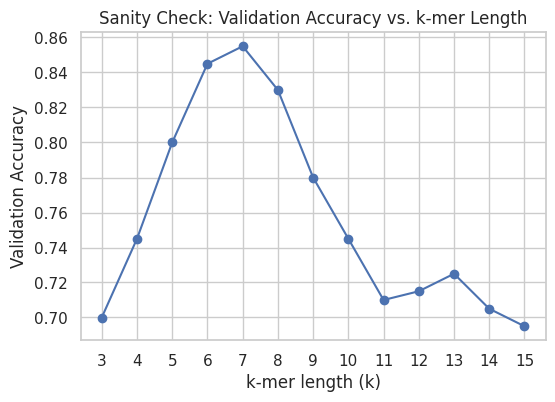

In [ ]:
# Cell 3: Sanity check over multiple k‑mer lengths

ks = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]   # k‑mer sizes to test
results = []

for k in ks:
    # Build k‑mer “documents” for train and val
    train_docs = train_df["sequence"].apply(lambda s: " ".join(s[i:i+k] for i in range(len(s)-k+1)))
    val_docs   = val_df["sequence"].apply(lambda s: " ".join(s[i:i+k] for i in range(len(s)-k+1)))
    y_train, y_val = train_df["label"].values, val_df["label"].values

    # Vectorize
    vec = TfidfVectorizer(ngram_range=(1,1))
    X_train_tfidf = vec.fit_transform(train_docs)
    X_val_tfidf   = vec.transform(val_docs)

    # Train & evaluate
    clf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
    preds = clf.predict(X_val_tfidf)
    acc = accuracy_score(y_val, preds)

    results.append({"k": k, "val_accuracy": acc})

# Results DataFrame
res_df = pd.DataFrame(results)
print(res_df)

# Plotting
plt.figure(figsize=(6,4))
plt.plot(res_df["k"], res_df["val_accuracy"], marker='o')
plt.title("Sanity Check: Validation Accuracy vs. k‑mer Length")
plt.xlabel("k‑mer length (k)")
plt.ylabel("Validation Accuracy")
plt.xticks(ks)
plt.grid(True)
plt.show()


In [ ]:
# Sanity check: can a simple k‑mer TF‑IDF + logistic regression learn above chance?
# Build k‑mer “documents”
k = 3
def kmer_doc(s):
    return " ".join([s[i:i+k] for i in range(len(s)-k+1)])

train_texts = train_df["sequence"].apply(kmer_doc)
val_texts   = val_df["sequence"].apply(kmer_doc)
y_train     = train_df["label"].values
y_val       = val_df["label"].values

# Vectorize 3‑mers
vectorizer = TfidfVectorizer(ngram_range=(1,1))
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf   = vectorizer.transform(val_texts)

# Quick logistic regression
clf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
preds = clf.predict(X_val_tfidf)
print("Sanity check — logistic regression val accuracy:", accuracy_score(y_val, preds))


Sanity check — logistic regression val accuracy: 0.7


In [ ]:

# Step 3: Define evaluation function and models
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": (preds == p.label_ids).mean()}

model = AutoModelForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", num_labels=2
)

models = [
    model
    # "distilbert-base-uncased",
    # "roberta-base",
    # "gpt2",
    # "distilgpt2"
]

results = []

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#NEW Cell 4: Build raw HF datasets & tokenizer
from transformers import AutoTokenizer

# Load Electra‐small tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")
tokenizer.pad_token = tokenizer.eos_token or tokenizer.pad_token

# Build raw HF datasets once
from datasets import Dataset
raw_train_ds = Dataset.from_pandas(train_df)
raw_val_ds   = Dataset.from_pandas(val_df)
raw_test_ds  = Dataset.from_pandas(test_df)

# Preprocess function: split on spaces, pass as `is_split_into_words`
def preprocess(examples):
    # examples["text"] is a space‑separated 6‑mer string
    kmer_lists = [txt.split(" ") for txt in examples["text"]]
    enc = tokenizer(
        kmer_lists,
        is_split_into_words=True,      # <-- preserves k‑mer tokens
        padding="max_length",
        truncation=True,
        max_length=64
    )
    enc["labels"] = examples["label"]
    return enc

# Accuracy metric
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": (preds == p.label_ids).mean()}


In [ ]:
#NEW Cell 5: Tokenize, train & evaluate
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import time

# 1) Tokenize each split once
train_ds = raw_train_ds.map(preprocess, batched=True,
    remove_columns=["sequence","label","text","__index_level_0__"],
    cache_file_name="cache/train_enc.arrow"    # so you can skip re-tokenizing
)
val_ds = raw_val_ds.map(preprocess, batched=True,
    remove_columns=["sequence","label","text","__index_level_0__"],
    cache_file_name="cache/val_enc.arrow"
)
test_ds = raw_test_ds.map(preprocess, batched=True,
    remove_columns=["sequence","label","text","__index_level_0__"],
    cache_file_name="cache/test_enc.arrow"
)

# 2) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", num_labels=2
)

# 3) TrainingArguments with epoch checkpoints
args = TrainingArguments(
    output_dir="results/electra",
    eval_strategy="epoch",   # eval every epoch
    save_strategy="epoch",         # save a checkpoint every epoch
    learning_rate=3e-5,
    warmup_steps=50,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,            # initial number of epochs
    logging_steps=10,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

# 4) Initial training
trainer.train()

# 5) Evaluate on test set
metrics = trainer.evaluate(test_ds)
print("✅ Test set results:", metrics)

# 6) If you want to train *x more* epochs from where you left off:
trainer.args.num_train_epochs += 10
trainer.train(resume_from_checkpoint=True)
metrics2 = trainer.evaluate(test_ds)
print("✅ After 10 epochs, test results:", metrics2)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693500,0.692678,0.500000
2,0.690800,0.690434,0.515000
3,0.700700,0.696243,0.530000
4,0.664100,0.682854,0.575000
5,0.679000,0.680374,0.580000


✅ Test set results: {'eval_loss': 0.681683361530304, 'eval_accuracy': 0.58, 'eval_runtime': 5.7957, 'eval_samples_per_second': 34.509, 'eval_steps_per_second': 2.243, 'epoch': 5.0}


Epoch,Training Loss,Validation Loss,Accuracy
11,0.597100,0.691781,0.590000
12,0.627400,0.695557,0.585000
13,0.548300,0.696713,0.590000
14,0.556100,0.703259,0.585000
15,0.549200,0.704740,0.585000


✅ After 10 epochs, test results: {'eval_loss': 0.734976589679718, 'eval_accuracy': 0.545, 'eval_runtime': 6.8656, 'eval_samples_per_second': 29.131, 'eval_steps_per_second': 1.893, 'epoch': 15.0}


In [ ]:

# Step 4: Train and evaluate each model
for model_name in models:
    print(f"\n Training {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    def preprocess(examples):
        tokens = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
        tokens["labels"] = examples["label"]
        return tokens

    # Prepare datasets
    train_ds = Dataset.from_pandas(train_df).map(preprocess, batched=True, remove_columns=["sequence", "label", "text", "__index_level_0__"])
    val_ds = Dataset.from_pandas(val_df).map(preprocess, batched=True, remove_columns=["sequence", "label", "text", "__index_level_0__"])
    test_ds = Dataset.from_pandas(test_df).map(preprocess, batched=True, remove_columns=["sequence", "label", "text", "__index_level_0__"])

    # Load and configure model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    args = TrainingArguments(
        output_dir=f"results/{model_name.replace('/', '_')}",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=3e-5,            # a bit higher than default
        warmup_steps=50,               # ramp the LR up for first 50 steps
        weight_decay=0.01,             # small decay on all weights
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,           #changed from 3 to 5
        logging_steps=10,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    metrics = trainer.evaluate(test_ds)
    acc = metrics["eval_accuracy"]
    results.append({"model": model_name, "accuracy": acc, "train_time": train_time})



 Training ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ElectraIntermediate(
            (dense): Linear(in_features=256, out_features=1024, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): ElectraOutput(
            (dense): Linear(in_features=1024, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (classifier): ElectraClassificationHead(
    (dense): Linear(in_features=256, out_features=256, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=256, out_features=2, bias=True)
  )
)'.

In [ ]:

# Step 5: Display and visualize results
res_df = pd.DataFrame(results)
res_df

In [ ]:

# Plot accuracy comparison
plt.figure(figsize=(8, 4))
sns.barplot(x="model", y="accuracy", data=res_df)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(8, 4))
sns.barplot(x="model", y="train_time", data=res_df)
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (s)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
